# Quantitative Developer Assignment – Ali Akhtari
--------

You can find a detailed description of the task in `readme.md`. In this notebook, I presume familiarity with the following subjects:
- Constrained Optimization
- Modern Portfolio Theory (MPT)
- Markowitz Portfolio Optimization
- Statistical notion of moments, correlation, and estimation

This notebook will include data retrieval and transformation, portfolio optimization, backtesting, and grid search for the allocation strategy parameters. We'll use `yfinance`, `coinmarketcap`, `pypfopt`, anf `zipline` libraries for most of the operations. You can find a simple diagram of the workflow below:

![Text here](./flow.png)

In [1]:
import itertools

import pandas as pd
import pypfopt as ppo
import matplotlib.pyplot as plt
import pypfopt.plotting as pfplt
import numpy as np
from zipline import run_algorithm
from zipline.api import order, record, symbol

from src import transform, api, backtest

In [2]:
CANDIDATES_FETCHED = 30
CANDIDATES_KEPT = 10

## Data Retrieval

The CoinMarketCap APIs are utilized to fetch the top twenty tickers based on market capitalization. These tickers are subsequently arranged in ascending order according to the date of their addition to the CMC database. To maximize the retrieval of historical data, the top 10 tickers from this list are selected.

In [3]:
candidates = api.fetch_candidates(limit=CANDIDATES_FETCHED)
candidates.sort(key=lambda i:pd.Timestamp(i['date_added']))
candidates = list(map(lambda i: i["symbol"], candidates[:CANDIDATES_KEPT]))

The historical price action is then fetched from Yahoo! Finance and cached. You can pass `reset_cache` flag to `fetch_ohlcv` to fetch fresh data.

In [4]:
raw_data = api.fetch_ohlcv()

In [5]:
raw_data.tail()

ETH-USD                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2023-07-17  1923.694336  1936.177612  1875.120361  1911.646118  1911.646118   
2023-07-18  1911.697021  1916.468384  1878.718506  1897.599243  1897.599243   
2023-07-19  1897.797241  1919.264404  1883.067139  1889.007935  1889.007935   
2023-07-20  1889.073730  1919.264404  1879.734375  1890.969116  1890.969116   
2023-07-22  1892.008789  1896.459106  1886.071411  1886.071411  1886.071411   

                          USDT-USD                                ...  \
                  Volume      Open      High       Low     Close  ...   
Date                                                              ...   
2023-07-17  6.678091e+09  1.000612  1.000972  0.999783  1.000220  ...   
2023-07-18  5.814708e+09  1.000272  1.000723  0.999562  1.000158  ...   
2023-07-19  6.018488e+09  1.000134  1.000852  0.999647  1.000230  ...   
2023-07-20  7.366831e+09  1.000173  1.000852  0.999616  1.000079  ...   
2023-07-22  4.127430e+09  1.000125  1.000582  0.999942  1.000235  ...   

             XRP-USD                                    DOGE-USD            \
                 Low     Close Adj Close        Volume      Open      High   
Date                                                                         
2023-07-17  0.718425  0.739205  0.739205  2.506419e+09  0.069558  0.072752   
2023-07-18  0.736093  0.779540  0.779540  2.626010e+09  0.069901  0.070257   
2023-07-19  0.774335  0.820694  0.820694  3.954595e+09  0.068589  0.071212   
2023-07-20  0.773945  0.794058  0.794058  2.843383e+09  0.070148  0.071022   
2023-07-22  0.768521  0.769194  0.769194  1.492905e+09  0.073258  0.073258   

                                                       
                 Low     Close Adj Close       Volume  
Date                                                   
2023-07-17  0.068255  0.069905  0.069905  464403123.0  
2023-07-18  0.067743  0.068583  0.068583  284882933.0  
2023-07-19  0.068487  0.070159  0.070159  418313611.0  
2023-07-20  0.068487  0.070516  0.070516  574227832.0  
2023-07-22  0.071073  0.071649  0.071649  673507392.0  

[5 rows x 60 columns]

## Ingestion
To use the data we just fetched in our backtests, we have to ingest it as a zipline data bundle. We'll follow this guide (https://zipline-trader.readthedocs.io/en/latest/bundles.html) on how to create new Zipline data bundles with CSV data.
Throughout our workflow, we need to transform price action data from `yfinance` schema to `zipline` and from that to `pypfopt`. Data transformer methods are all placed in `src.tranasform` module.

In [24]:
zp_data = transform.yfinance2zipline(raw_data, "zipline")

Now we have to edit `~/.zipline/extension.py` and add the following code:

```
from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

register(
    "genie",
    csvdir_equities(
        ["daily"],
        "YOUR SAVEDIR HERE",
    ),
    calendar_name="24/7",
)
```

And finally run: `zipline ingest -b genie` in terminal.

## Portfolio Optimization

We'll use `pypfopt` to solve the optimization problem given methods to compute expected returns and covariances and `zipline` to backtest allocation strategies. In this section, we only use sample historical returns and covariance to estimate the parameters, but, in the next sections we test different estimators.

In [6]:
data = transform.yfinance2pypfopt(raw_data)

/var/folders/ts/xsr5s4hn2zs46ml6rgb5_42m0000gp/T/ipykernel_7071/1274277298.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


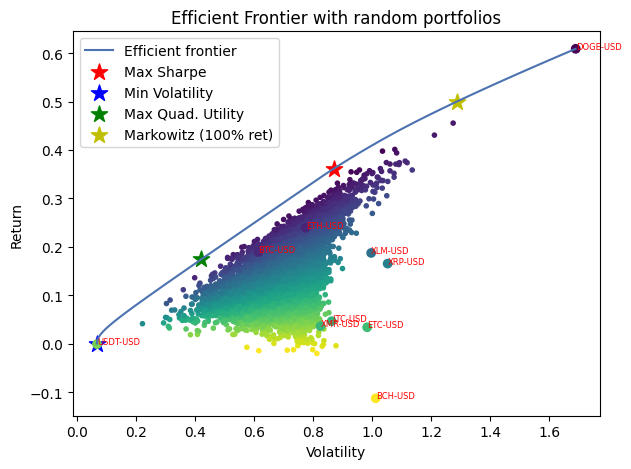

In [21]:
mu = ppo.expected_returns.mean_historical_return(data)
S = ppo.risk_models.risk_matrix(data)
ef = ppo.EfficientFrontier(mu, S, weight_bounds=(0,1))

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
ef_min_vol = ef.deepcopy()
ef_max_util = ef.deepcopy()
ef_markowitz = ef.deepcopy()
pfplt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=150, c="r", label="Max Sharpe")

ef_min_vol.min_volatility()
ret_tangent, std_tangent, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=150, c="b", label="Min Volatility")

ef_max_util.max_quadratic_utility(risk_aversion=1)
ret_tangent, std_tangent, _ = ef_max_util.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=150, c="g", label="Max Quad. Utility")

ef_markowitz.efficient_return(target_return=.5)
ret_tangent, std_tangent, _ = ef_markowitz.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=150, c="y", label="Markowitz (100% ret)")



# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples) 
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Add single assets
assets = ef.clean_weights().keys()
w_assets = np.array([np.lib.pad([1],(ix,9-ix),'constant', constant_values=(0)) for ix in range(10)])
rets_assets = w_assets.dot(ef.expected_returns)
stds_assets = np.sqrt(np.diag(w_assets @ ef.cov_matrix @ w_assets.T))
sharpes_assets = rets_assets / stds_assets
ax.scatter(stds_assets, rets_assets, marker="o", c=sharpes_assets, cmap="viridis_r")
for i, txt in enumerate(assets):
    ax.annotate(txt, (stds_assets[i], rets_assets[i]), size=6, color="r")


# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

It's evident that DOGE and USDT, positioned at the opposite ends of the volatility spectrum, are outliers in terms of risk and return distribution. Employing an optimization strategy solely based on Sharpe ratio could result in excessive volatility and significant drawdowns over the long term. Additionally, the inherent high volatility of cryptocurrency markets implies that return estimates are even more uncertain compared to conventional markets. Hence, we refrain from relying on Sharpe Ratio in the objective value of the optimization problem.

## Backtesting and Optimization

We initiate an instance of the class `Initialize` to pass the backtesting parameters to `zipline`'s `initialize` method. The parameters include:
- `get_returns_est`: a method that calculates return estimates ([more explanation](https://pyportfolioopt.readthedocs.io/en/latest/ExpectedReturns.html); [example](https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/expected_returns.html#mean_historical_return))
- `get_risk_model`: a method that calculates covariance estimates ([more explanation](https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html); [example](https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/risk_models.html#CovarianceShrinkage.ledoit_wolf))  
- `optimizer_prop`: property name of the optimizer in `pypfopt` to use, must be one of "min_volatility", "max_sharpe", or "max_quadratic_utility"

As anticipated, our experiments confirm that incorporating Sharpe Ratio as the objective leads to extreme outcomes, with either exceptional returns or complete erosion of capital (or, in situations where credit is accessible, significantly negative portfolio values). For now, we restrict our grid search to minimizing volatility.

We can later introduce a more sophisticated risk appetite using a quadratic utility and optimize for risk aversion.

You can find the code for running the grid search in `src/run.py`. In this part, we'll investigate the parameters used in the grid search further.

### Risk Models
Historical covariance exhibits a more predictable characteristic compared to mean historical returns. As such, when constructing portfolios, those that take into account the volatility tend to outperform those solely relying on return estimations.

**Sample Covariance** The most straightforward way to estimate future volatility is using annualized covariance of past daily returns.

**Exponential Covariance** Exponentially-weighted covariance matrix assigns greater significance to more recent data, similar to how the exponential moving average price is often favored over the simple average price. [read more](https://reasonabledeviations.com/2018/08/15/exponential-covariance/)

**Shrinkage Models** The main idea behind shrinkage models is to find a compromise between a structured but biased estimator with an unbiased estimator that has high variance. For our optimization purposes, we use two shrinkage models: [Ledoit-Wolf constant variance](https://www.pm-research.com/content/iijpormgmt/30/4/110) (the biased estimator is the diagonal matrix with the mean of asset variances) and Oracle approximating shrinkage ([OAS](https://arxiv.org/pdf/0907.4698.pdf)).

Let's delve deeper into the Ledoit-Wolf estimators and explore their various classes. There are three distinct categories of LW estimators:

1. Constant Variance Shrinkage:
This class of estimators uses a diagonal matrix with the asset mean variances as the biased estimator.

1. Single-Factor Shrinkage:
The single-factor shrinkage approach derives inspiration from Sharpe's single-index model, where the risk model effectively utilizes a stock's beta to the market.

1. Constant Correlation Shrinkage:
All pairwise correlations are adjusted to match the average correlation while keeping the sample variances unchanged.

When it comes to cryptocurrencies, the applicability of a single-index model is not ideal. Moreover, maintaining invariant correlations does not contribute significantly to the model's effectiveness, especially considering the variation in covariances within our portfolio and the high correlation between crypto assets. While we employ a constant variance shrinkage method, it is crucial to emphasize that **within our sample, DOGE and USDT exhibit outliers in terms of variance. Simply pushing their variances closer to the mean does not necessarily enhance the reliability of our estimates.**


### Returns estimators
We leverage Simple Moving Averages (SMA) and Exponential Moving Averages (EMA) of historical prices to estimate future prices. However, in the context of cryptocurrencies, this strategy can be risky and potentially result in significant losses. In circumstances where our optimization is primarily focused on minimizing volatility, these return estimates become less of a concern for us. When introducing a risk appetite through a quadratic utility, we may consider the Black-Litterman model to moderate our price estimates.

## Findings
The optimization results can be accessed within the `res/` directory.

### Exponential Covariance
With exponential covariance, magnifying the effect of recent observations led to increased stability compared to sample covariance.

<img src="res/exp_cov_sample_rets_ema_0_min_volatility.png" style="width:700px;"/>

### Sample Covariance
Using sample covariance during periods of major shifts in markets lead to extremely inaccurate estimates and loss of capital.

<img src="res/sample_cov_sample_rets_ema_0_min_volatility.png" style="width:700px;"/>

### OAS
All in all, the long-only OAS appeared to yield the most desirable results. Despite experiencing a significant drawdown in 2021, the model's performance remained largely unscathed during other periods, demonstrating resilience amidst the extreme volatility that plagued most iterations in late 2022.

<img src="res/oracle_approximating_sample_rets_-1_min_volatility.png" style="width:700px;"/>

### LW
Corroborating our predictions, employing the LW constant variance target did not definitively enhance the stability of our portfolio. In fact, it may have inadvertently pushed the variance of USDT and DOGE towards the mean. Consequently, this strategy became extremely volatile when leveraging compared to other estimators.

<img src="res/ledoit_wolf_sample_rets_-1_
min_volatility.png" style="width:700px;"/>


## Further Improvements

Here I discuss improvements that I didn't get to implement due to time limitations and open-ended questions I faced during this project that intrigued me.

### Software
While integrating CMC, `yfinance`, `pypfopt`, and `zipline` proved to be more difficult than I expected it, the final solution is fully modular and streamlined. However, by lifting the state up from `backtest` module to `run`, I could allow full customization in weight selection when running the backtest. Basically, the user would pass a `set_weights` function to `backtest.Initialize` that takes `context` and `data` and sets the portfolio weights. This would facilitate testing but also allow users to use all the features within `pypfopt` (Black-Litterman model, Hierarchian-Risk Parity, custom objective functions, etc.).

Also, the data ingestion process for `zipline` can be further automated to eliminate the need for any manual transformation.

### Backtesting Library
While `zipline` comes with more features and boilerplate code, I'd use another backtesting library, for example, `bt`, for an enterprise-grade optimization toolkit to increase modularity and remove overhead.

### Black-Litterman
Similar to how shrinkage estimators for covariance make the estimates more mild, we could introduce mean-reverting views to Black-Litterman model on top of market-implied returns to find a compromise between mean-reversion and trend-following. I'm still not optimistic, however, about attempts to provide reliable return estimates in crypto markets.

### Quadratic Utility
While quadratic utility objective with the default risk parameter is still highly volatile, it would be interesting to introduce sophisticated risk aversion profiles to the optimization. With quadratic utility objective, the model optimizes for $$\max_w w^T \mu - \frac \delta 2 w^T \Sigma w$$ with $\delta$ a positive number representing decision maker's risk aversion, $w$ the optimization variable, $\mu$ the estimated returns, and $\Sigma$ the estimated covariance matrix.

### Hierarchical Risk Parity
HRP is a portfolio optimization algorithm that uses hierarchical clustering based on the covariance matrix as distance and iterates over the tree to select assets. Portfolios formed by HRP are shown to be less concentrated and more stable ([see](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678)). Once weight computation and optimization is fully encapsulated from the backtesting logic, an HRP algorithm could be injected into the backtesting suite as the optimizer ([see](https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html)).

### Leverage and Trade Management
One clear issue with most of the strategies is their inability to cut losses but also to manage reasonable leverage (especially in cases where shorting is allowed). Sophisticated logic to determine leverage and include stop loss/take profit can be injected as modules into the backtesting suite.